# Data Preprocessing

In [1]:
!pip install datasets

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch
import albumentations as A

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
from datasets import load_dataset

dataset1 = load_dataset("EduardoPacheco/FoodSeg103")

README.md:   0%|          | 0.00/6.71k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/351M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/357M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/431M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4983 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2135 [00:00<?, ? examples/s]

In [4]:
print(dataset1)

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'classes_on_image', 'id'],
        num_rows: 4983
    })
    validation: Dataset({
        features: ['image', 'label', 'classes_on_image', 'id'],
        num_rows: 2135
    })
})


In [5]:
from datasets import DatasetDict

# Define the split ratio (e.g., 80% train, 20% dev)
split_ratio = 0.8

# Split the `train` dataset into new train and dev sets
train_val_split = dataset1['train'].train_test_split(test_size=1 - split_ratio)

# Access the newly created splits
new_train_dataset = train_val_split['train']  # 80% of the original train set
new_dev_dataset = train_val_split['test']     # 20% of the original train set

# Now, we have:
# new_train_dataset -> the new train split
# new_dev_dataset -> the new dev split

# If needed, we can create a new DatasetDict that includes the updated train and dev sets
dataset = DatasetDict({
    'train': new_train_dataset,
    'dev': new_dev_dataset,
    'test': dataset1['validation']  # Keeping the original validation set
})

# You can now use `updated_dataset_dict` for further processing or save it to disk.


In [6]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'classes_on_image', 'id'],
        num_rows: 3986
    })
    dev: Dataset({
        features: ['image', 'label', 'classes_on_image', 'id'],
        num_rows: 997
    })
    test: Dataset({
        features: ['image', 'label', 'classes_on_image', 'id'],
        num_rows: 2135
    })
})


### Save Data as Dataset

In [7]:
from sklearn.model_selection import train_test_split
import os
import numpy as np
import cv2

# Define directories for the new train and dev sets
train_images_dir = "/kaggle/working/yolo/images/train"
train_labels_dir = "/kaggle/working/yolo/labels/train"
train_masks_dir = "/kaggle/working/yolo/masks/train"
dev_images_dir = "/kaggle/working/yolo/images/dev"
dev_labels_dir = "/kaggle/working/yolo/labels/dev"
dev_masks_dir = "/kaggle/working/yolo/masks/dev"
test_images_dir = "/kaggle/working/yolo/images/test"
test_labels_dir = "/kaggle/working/yolo/labels/test"
test_masks_dir = "/kaggle/working/yolo/masks/test"


os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(dev_images_dir, exist_ok=True)
os.makedirs(dev_labels_dir, exist_ok=True)
os.makedirs(test_images_dir, exist_ok=True)
os.makedirs(test_labels_dir, exist_ok=True)

In [8]:
import numpy as np
import os
import cv2
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define the augmentation pipeline
augmentations = A.Compose([
    A.Resize(640, 640),  # Resize to a fixed size
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.1),
    A.Rotate(limit=5, p=0.3),
    A.ColorJitter(p=0.2),
    ToTensorV2()
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_visibility=0.2))

# Function to apply augmentations and convert to YOLO format
def augment_image(image, seg_map):
    """
    Apply augmentations to an image and its corresponding segmentation map.
    Args:
        image (np.array): Input image as a NumPy array.
        seg_map (np.array): Corresponding segmentation map as a NumPy array.
    Returns:
        Augmented image, augmented bounding boxes, augmented class labels.
    """
    bboxes = convert_segmentation_to_yolo({"image": image, "label": seg_map})
    class_labels = [bbox[0] for bbox in bboxes]  # Extract class IDs
    yolo_bboxes = [bbox[1:] for bbox in bboxes]  # Extract normalized bounding box coords

    # Apply augmentations to both image and segmentation mask
    augmented = augmentations(image=image, bboxes=yolo_bboxes, class_labels=class_labels)
    
    # Return augmented image, bounding boxes, and class labels
    return augmented['image'], augmented['bboxes'], augmented['class_labels']


def convert_segmentation_to_yolo(example):
    image = np.array(example["image"])
    seg_map = np.array(example["label"])
    
    bboxes = []
    for class_id in np.unique(seg_map):
        if class_id == 0:
            continue  # Skip background class

        # Find bounding box coordinates for the current class
        mask = seg_map == class_id
        y_indices, x_indices = np.where(mask)
        if len(y_indices) == 0 or len(x_indices) == 0:
            continue

        x_min, x_max = x_indices.min(), x_indices.max()
        y_min, y_max = y_indices.min(), y_indices.max()

        # Calculate the bounding box in YOLO format (normalized)
        x_center = (x_min + x_max) / 2 / image.shape[1]
        y_center = (y_min + y_max) / 2 / image.shape[0]
        width = (x_max - x_min) / image.shape[1]
        height = (y_max - y_min) / image.shape[0]

        # Check for invalid boxes (width or height close to zero)
        if width <= 0 or height <= 0:
            continue  # Skip invalid boxes

        # Clip values to ensure they are within the range (0, 1]
        x_center = max(0, min(x_center, 1))
        y_center = max(0, min(y_center, 1))
        width = max(0, min(width, 1))
        height = max(0, min(height, 1))

        bboxes.append((class_id, x_center, y_center, width, height))
    
    return bboxes

# Function to extract polygon points from the mask
def get_polygon_points(mask):
    """
    Convert a binary mask to polygon points for YOLO segmentation format.
    
    Args:
        mask (np.array): The binary mask for a specific object.
        
    Returns:
        List of normalized polygon points [(x1, y1), (x2, y2), ...].
    """
    # Find contours of the mask (returns a list of points outlining the object)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Normalize the polygon points
    polygon_points = []
    for contour in contours:
        for point in contour:
            x, y = point[0]
            polygon_points.append((x / mask.shape[1], y / mask.shape[0]))  # Normalize to [0,1] range
    
    return polygon_points


# Function to convert tensor to NumPy and save it as an image
def save_image(image_tensor, image_path):
    """
    Convert a PyTorch tensor or Albumentations image to a NumPy array and save it.
    
    Args:
        image_tensor (torch.Tensor or numpy.ndarray): The image to save.
        image_path (str): The path to save the image.
    """
    # Check if the image is a PyTorch tensor and convert it to a NumPy array
    if isinstance(image_tensor, torch.Tensor):
        # Convert from C x H x W to H x W x C and scale from [0, 1] to [0, 255]
        image = image_tensor.permute(1, 2, 0).cpu().numpy() * 255
        image = image.astype(np.uint8)
    elif isinstance(image_tensor, np.ndarray):
        # If it's already a NumPy array but might be in float format, convert to uint8
        if image_tensor.max() <= 1.0:
            image = (image_tensor * 255).astype(np.uint8)
        else:
            image = image_tensor.astype(np.uint8)
    else:
        raise ValueError("Unsupported image type. Expected a torch.Tensor or np.ndarray.")
    
    # Save the image using OpenCV
    cv2.imwrite(image_path, image)


# Function to save YOLO format data (bounding boxes + segmentation polygons)
def save_yolo_format_seg(dataset, images_dir, labels_dir, prefix="train"):
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    for example in dataset:
        # Convert image to numpy array
        image = np.array(example["image"])
        seg_map = np.array(example["label"])
        image_id = str(example["id"])  # Use the 'id' field as the file name base

        # Apply augmentations
        augmented_image, augmented_bboxes, augmented_labels = augment_image(image, seg_map)

        # Save the augmented image
        image_path = os.path.join(images_dir, f"{image_id}.jpg")
        save_image(augmented_image, image_path)

        # Save the augmented bounding box annotations and polygon points to a .txt file
        label_path = os.path.join(labels_dir, f"{image_id}.txt")
        with open(label_path, "w") as f:
            for class_id, (x_center, y_center, width, height) in zip(augmented_labels, augmented_bboxes):
                # Write class ID and bounding box (YOLO format)
                f.write(f"{int(class_id)} {x_center} {y_center} {width} {height} ")
                
                # Extract polygon points from the mask for the current object
                object_mask = (seg_map == class_id).astype(np.uint8)  # Binary mask for this object
                polygon_points = get_polygon_points(object_mask)
                
                # Write polygon points (normalized)
                polygon_str = " ".join([f"{x} {y}" for x, y in polygon_points])
                f.write(polygon_str + "\n")

        print(f"Saved {image_path} and {label_path}")

# Example usage
save_yolo_format_seg(dataset['train'], train_images_dir, train_labels_dir, prefix="train")
save_yolo_format_seg(dataset['dev'], dev_images_dir, dev_labels_dir, prefix="val")
save_yolo_format_seg(dataset['test'], test_images_dir, test_labels_dir, prefix="test")


Saved /kaggle/working/yolo/images/train/189.jpg and /kaggle/working/yolo/labels/train/189.txt
Saved /kaggle/working/yolo/images/train/408.jpg and /kaggle/working/yolo/labels/train/408.txt
Saved /kaggle/working/yolo/images/train/416.jpg and /kaggle/working/yolo/labels/train/416.txt
Saved /kaggle/working/yolo/images/train/3859.jpg and /kaggle/working/yolo/labels/train/3859.txt
Saved /kaggle/working/yolo/images/train/1803.jpg and /kaggle/working/yolo/labels/train/1803.txt
Saved /kaggle/working/yolo/images/train/4015.jpg and /kaggle/working/yolo/labels/train/4015.txt
Saved /kaggle/working/yolo/images/train/1161.jpg and /kaggle/working/yolo/labels/train/1161.txt
Saved /kaggle/working/yolo/images/train/1836.jpg and /kaggle/working/yolo/labels/train/1836.txt
Saved /kaggle/working/yolo/images/train/3404.jpg and /kaggle/working/yolo/labels/train/3404.txt
Saved /kaggle/working/yolo/images/train/3528.jpg and /kaggle/working/yolo/labels/train/3528.txt
Saved /kaggle/working/yolo/images/train/2314.j

In [9]:
# Save the YAML configuration file for YOLO training
yaml_content = f"""
path: /kaggle/input/foodseg103-yolomseg/yolo
train: images/train
val: images/dev
test: images/test

nc: 104  # Number of classes, including background
names: [
    "background", "candy", "egg tart", "french fries", "chocolate", 
    "biscuit", "popcorn", "pudding", "ice cream", "cheese butter", 
    "cake", "wine", "milkshake", "coffee", "juice", "milk", "tea", 
    "almond", "red beans", "cashew", "dried cranberries", "soy", 
    "walnut", "peanut", "egg", "apple", "date", "apricot", "avocado", 
    "banana", "strawberry", "cherry", "blueberry", "raspberry", "mango", 
    "olives", "peach", "lemon", "pear", "fig", "pineapple", "grape", 
    "kiwi", "melon", "orange", "watermelon", "steak", "pork", 
    "chicken duck", "sausage", "fried meat", "lamb", "sauce", "crab", 
    "fish", "shellfish", "shrimp", "soup", "bread", "corn", "hamburg", 
    "pizza", "hanamaki baozi", "wonton dumplings", "pasta", "noodles", 
    "rice", "pie", "tofu", "eggplant", "potato", "garlic", "cauliflower", 
    "tomato", "kelp", "seaweed", "spring onion", "rape", "ginger", 
    "okra", "lettuce", "pumpkin", "cucumber", "white radish", "carrot", 
    "asparagus", "bamboo shoots", "broccoli", "celery stick", 
    "cilantro mint", "snow peas", "cabbage", "bean sprouts", "onion", 
    "pepper", "green beans", "French beans", "king oyster mushroom", 
    "shiitake", "enoki mushroom", "oyster mushroom", 
    "white button mushroom", "salad", "other ingredients"
]
"""

with open("/kaggle/working/yolo/dataset.yaml", "w") as file:
    file.write(yaml_content)

# Data Analysis

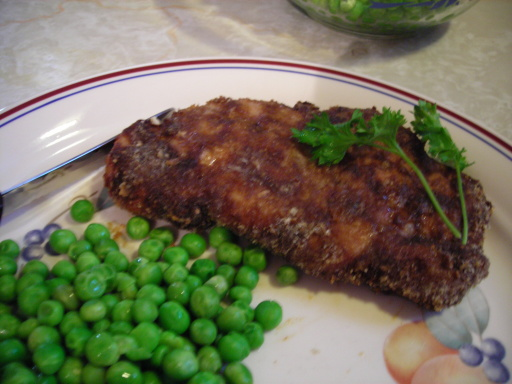

In [10]:
example = dataset["train"][1]
image = example["image"]
image

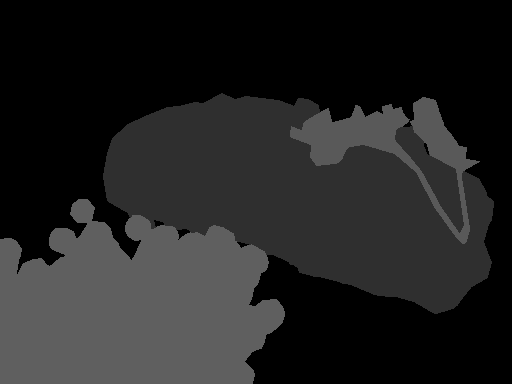

In [11]:
seg = example["label"]
seg

In [12]:
img_class = example["classes_on_image"]
img_class

[0, 47, 89, 95]

In [13]:
id = example["id"]
id

408

In [14]:
seg = np.array(seg)
seg

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [95, 95, 95, ...,  0,  0,  0],
       [95, 95, 95, ...,  0,  0,  0],
       [95, 95, 95, ...,  0,  0,  0]], dtype=uint8)